Run shell commands in Jupyter notebooks

In [2]:
!ls -l data/

total 4096
-rwxrwx--- 1 zhang mkpasswd 6401454 Mar 26 05:49 BacillusBrevis.fa
-rwxrwx--- 1 zhang mkpasswd   12425 Apr 14 06:13 CCGenotypes.csv
-rwxrwx--- 1 zhang mkpasswd 1875627 Jan 21  2020 GenomeA.fa
-rwxrwx--- 1 zhang mkpasswd 1875627 Jan 21  2020 GenomeB.fa
-rwxrwx--- 1 zhang mkpasswd 1846362 Jan 21  2020 ThermotogaPetrophila.fa
-rwxrwx--- 1 zhang mkpasswd 4191517 Jan 21  2020 VibrioCholerae.fa


In [3]:
!head data/VibrioCholerae.fa

>gi|146313784|gb|CP000626.1| Vibrio cholerae O395 chromosome 1, complete genome
ACAATGAGGTCACTATGTTCGAGCTCTTCAAACCGGCTGCGCATACGCAGCGGCTGCCATCCGATAAGGT
GGACAGCGTCTATTCACGCCTTCGTTGGCAACTTTTCATCGGTATTTTTGTTGGCTATGCAGGCTACTAT
TTGGTTCGTAAGAACTTTAGCTTGGCAATGCCTTACCTGATTGAACAAGGCTTTAGTCGTGGCGATCTGG
GTGTGGCTCTCGGTGCGGTTTCAATCGCGTATGGTCTGTCTAAATTTTTGATGGGGAACGTCTCTGACCG
TTCTAACCCGCGCTACTTTCTGAGTGCAGGTCTACTCCTTTCGGCACTAGTGATGTTCTGCTTCGGCTTT
ATGCCATGGGCAACGGGCAGCATTACTGCGATGTTTATTCTGCTGTTCTTAAACGGCTGGTTCCAAGGCA
TGGGTTGGCCTGCTTGTGGCCGTACTATGGTGCACTGGTGGTCACGCAAAGAGCGTGGTGAGATTGTTTC
GGTCTGGAACGTCGCTCACAACGTCGGTGGTGGTTTGATTGGCCCCATTTTCCTGCTCGGCCTATGGATG
TTTAACGATGATTGGCGCACGGCCTTCTATGTCCCCGCTTTCTTTGCGGTGCTGGTTGCCGTATTTACTT


## A function to load sequences from a FASTA formatted file 

In [4]:
import gzip

def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into two lists. One of 
        headers and a second list of sequences.
        The ith index of each list correspond."""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # split at headers
    data = fp.read().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)

## A k-mer count method 
This function creates a list of the genome positions where each *k-mer* appears. Each dictionary entry contains list of positions for one k-mer. The length of these lists are the same as the k-mer counts. We also merge the postions of each k-mer with its reverse complement using the key which is *lexigraghically* (alphabetical in our case) first. 

In [5]:
def kmerPositions(k, sequence):
    """ returns the position of all k-mers in sequence as a dictionary"""
    kmerPosition = {}
    for i in range(len(sequence)-k+1):
        kmer = sequence[i:i+k]
        kmerPosition[kmer] = kmerPosition.get(kmer,[])+[i]
    # combine kmers with their reverse complements
    pairPosition = {}
    for kmer, posList in kmerPosition.items():
        krev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(kmer)])   # one-liner
        if (kmer < krev):
            pairPosition[kmer] = sorted(posList + kmerPosition.get(krev, []))
        elif (krev < kmer):
            pairPosition[krev] = sorted(kmerPosition.get(krev, []) + posList)
        else:
            pairPosition[kmer] = posList
    return pairPosition

## Read a genome from a FASTA file
Read the genome of Vibrio Cholerae.

In [6]:
header, seq = loadFasta("data/VibrioCholerae.fa")

for i in range(len(header)):
    print(header[i])
    print(len(seq[i])-1, "bases", seq[i][:30], "...", seq[i][-30:])
    print()

# use the first seq (chromosome)
genome = seq[0]

gi|146313784|gb|CP000626.1| Vibrio cholerae O395 chromosome 1, complete genome
1108249 bases ACAATGAGGTCACTATGTTCGAGCTCTTCA ... CCGATAGTAGAGGTTTATACCATCGCAAAA

gi|147673035|ref|NC_009457.1| Vibrio cholerae O395 chromosome 2, complete genome
3024068 bases GTTCGCCAGAGCGGTTTTTGACTAGCTTGA ... TTTCTGGGTTAAACAGATACTCGGGGCTGG



## Find the most frequent *k-mers* 

In [7]:
k = 9
kmers = kmerPositions(k, genome)
kmer_counts = {}
for kmer, posList in kmers.items():
    kmer_counts[kmer] = len(posList)
# find the 10 most frequent kmers 
top10 = [kmer for kmer in sorted(kmer_counts, reverse=True, key=kmer_counts.get)][:10]
for kmer in top10:
    print(kmer, kmer_counts[kmer]) 

AAACTCAAA 141
AACAAACGC 138
ACAAACGCC 130
CGGGCGTTA 128
AACGCCCGC 127
AAACGCCTC 125
GCGTTTCCA 125
ACTGGAAAC 124
CGTTTGTTA 124
AACGCCTCA 122


## Let's look at where these k-mers are
We focus on top-10 most frequent k-mers

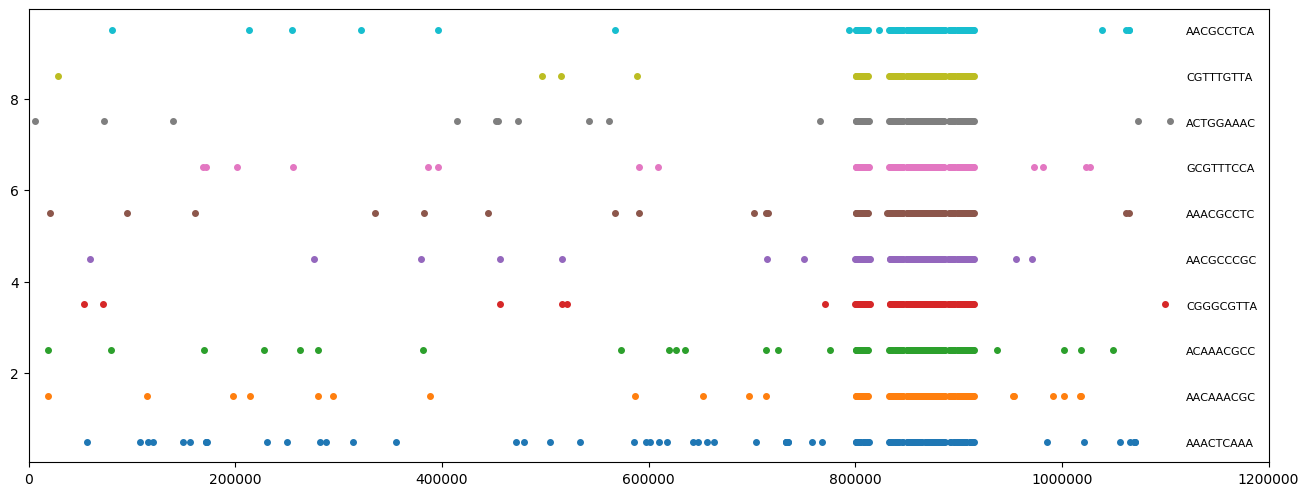

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(16, 6), dpi=100, facecolor='w', edgecolor='k')
#plt.plot([OriCStart, OriCStart], [0,10], 'k--')
for n, kmer in enumerate(top10):
    positions = kmers[kmer]
    plt.text(1120000, n+0.4, kmer, fontsize=8)
    plt.plot(positions, [n + 0.5 for i in range(len(positions))], 'o', markersize=4.0)
limit = plt.xlim((0,1200000))